## Do the Estimation with SCE and SPF data


### 1. Importing estimation algorithms 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.tsa.api import AR

In [52]:
from GMMEst import RationalExpectation as re
from GMMEst import StickyExpectation as se
from GMMEst import NoisyInformation as ni
from GMMEst import ParameterLearning as pl
from GMMEst import AR1_simulator, ForecastPlotDiag, ForecastPlot

In [3]:
## some parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

### 2. Preparing real-time data 

In [4]:
## CPI Core
InfCPICMRT=pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT=pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [5]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [6]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [7]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [8]:
## turn index into yearly inflation
real_time_index =pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [9]:
real_time_inf.tail()

,RTCPI,RTCPICore
date,,
2019-03-01,2.019516,1.878442
2019-04-01,2.060831,1.977897
2019-05-01,2.002032,1.844054
2019-06-01,2.136764,1.773122
2019-07-01,2.186252,1.940021


### 3. Estimating using real-time inflation and expectation data


In [10]:
## exapectation data from SPF 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]

dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')


In [11]:
## Inflation data quarterly 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2,freq='infer')

In [12]:
## process parameters estimation 
# period filter 
start_t='1995-01-01'
end_t = '2019-03-30'   # the same period as in Gali (1991)

### quarterly data 
CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]
Y = np.array(CPICQ[1:])
X = np.array(CPICQ[:-1])

ARmodel = AR(CPICQ)
ar_rs = ARmodel.fit(1,trend='nc')
rhoQ_est = ar_rs.params[0]
sigmaQ_est = np.sqrt(sum(ar_rs.resid**2)/(len(CPICQ)-1))

In [13]:
## Inflation data monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [14]:
### monthly data 
CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]
Y = np.array(CPIM[1:])
X = np.array(CPIM[:-1])

ARmodel2 = AR(CPIM)
ar_rs2 = ARmodel2.fit(1,trend='nc')
rhoM_est = ar_rs2.params[0]
sigmaM_est = np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [15]:
## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')

PopM = PopM[-PopM.date.isnull()]

dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')

dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']].dropna(how='any')

In [16]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,InfQ['Inf1y_CPICore'],InfQ['Inf1yf_CPICore']], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,real_time_inf,InfM['Inf1yf_CPIAU']], join='inner', axis=1)

In [17]:
## hisotries data, the series ends at the same dates with real-time data but startes earlier 

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

historyQ = real_time_inf.copy().loc[st_t_history:ed_t_SPF]
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

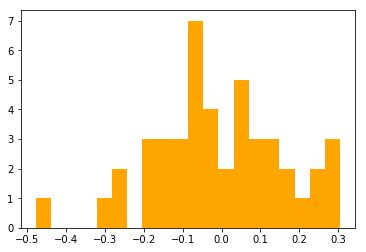

In [18]:
# How large is the difference between current vintage and real-time data
rev = SPF_est['Inf1y_CPICore'] - SPF_est['RTCPI']
hist_rv = plt.hist(rev,bins=20,color='orange')

Text(0.5, 1.0, 'Current vintage and real-time Core CPI Inflation')

<Figure size 432x288 with 0 Axes>

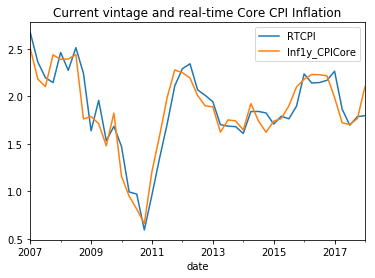

In [19]:
# real time inflation 
real_time = np.array(SPF_est['RTCPI'])


xx = plt.figure()
SPF_est[['RTCPI','Inf1y_CPICore']].plot()
plt.title('Current vintage and real-time Core CPI Inflation')

Text(0.5, 1.0, 'Realized 1-year-ahead Core CPI Inflation')

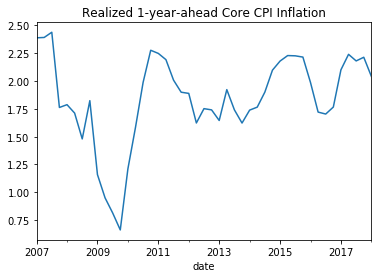

In [20]:
## realized 1-year-ahead inflation
realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])
SPF_est['Inf1yf_CPICore'].plot()
plt.title('Realized 1-year-ahead Core CPI Inflation')

In [21]:
## preparing for estimation 

exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SCE = dict(exp_data_SCE)

In [22]:
## SE estimation for SPF
real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']

data_moms_dct = data_moms_dct_SPF


process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

SE_model = se(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est)
SE_model.moments = ['Forecast','FE','Disg']
SE_model.GetRealization(realized_CPIC)
SE_model.GetDataMoments(data_moms_dct)
SE_model.ParaEstimate()

Optimization terminated successfully.
         Current function value: 8.524652
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6


In [23]:
lbd_est_SPF = SE_model.para_est
lbd_est_SPF

array([0.22667517])

In [24]:
## SE estimation for SCE
real_time = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dct = data_moms_dct_SCE


process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

SE_model2 = se(real_time = realized_CPI,
               history = history_M,
               process_para = process_paraM_est)
SE_model2.moments = ['Forecast','FE','Disg']
SE_model2.GetRealization(realized_CPI)
SE_model2.GetDataMoments(data_moms_dct)
SE_model2.ParaEstimate()

lbd_est_SCE = SE_model2.para_est

Optimization terminated successfully.
         Current function value: 167.452258
         Iterations: 4
         Function evaluations: 54
         Gradient evaluations: 18


In [25]:
## what is the estimated lambda?
print("SPF: "+str(lbd_est_SPF))
print("SCE: "+str(lbd_est_SCE))

## rough estimation that did not take care of following issues
## quarterly survey of 1-year-ahead forecast
## real-time data is yearly 

SPF: [0.22667517]
SCE: [0.02434184]


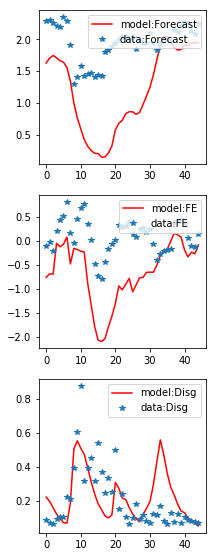

In [26]:
## compare the data with estimation for SPF
SE_model.ForecastPlotDiag()

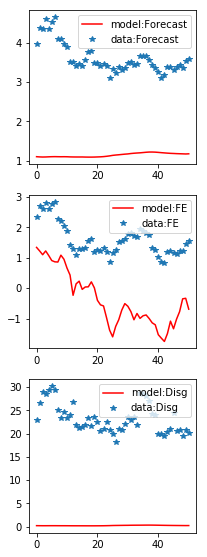

In [27]:
## compare the data with estimation for SPF
SE_model2.ForecastPlotDiag()

In [28]:
## NI estimation for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

NI_model = ni(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg'])
NI_model.SimulateSignals()
NI_model.GetRealization(realized_CPIC)
NI_model.GetDataMoments(data_moms_dct)
NI_model.ParaEstimate(para_guess = np.array([0.01,0.01,0.01]))

sigmas_est_SPF = NI_model.para_est

Optimization terminated successfully.
         Current function value: 9.151724
         Iterations: 11
         Function evaluations: 135
         Gradient evaluations: 27


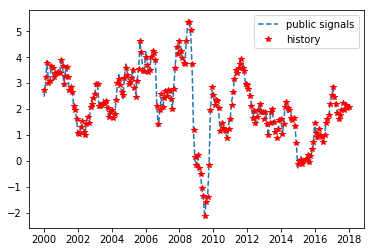

In [29]:
plt.plot(NI_model.signals_pb,'--',label='public signals')
plt.plot(NI_model.history,'r*',label='history')
plt.legend()

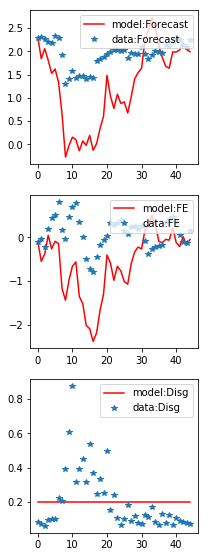

In [30]:
## compare the data with estimation for SPF
NI_model.ForecastPlotDiag()

In [31]:
## NI estimation for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

NI_model2 = ni(real_time = real_time,
               history = history_M,
               process_para = process_paraM_est)
NI_model2.SimulateSignals()
NI_model2.GetRealization(realized_CPI)
NI_model2.GetDataMoments(data_moms_dct)
NI_model2.moments = ['Forecast','FE','Disg']
NI_model2.ParaEstimate(para_guess=np.array([0.01,0.01,0.01]))

sigmas_est_SCE = NI_model2.para_est

Optimization terminated successfully.
         Current function value: 27.388892
         Iterations: 32
         Function evaluations: 330
         Gradient evaluations: 66


In [32]:
sigmas_est_SCE

array([7.51604876e-06, 4.89750721e+00, 1.00000000e-02])

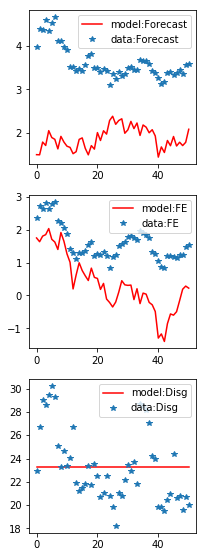

In [33]:
## compare the data with estimation for SCE

NI_model2.ForecastPlotDiag()

In [34]:
print(str(sigmas_est_SPF))
print(str(sigmas_est_SCE))

[-5.76007551e-09  4.56319995e-01  1.00000000e-02]
[7.51604876e-06 4.89750721e+00 1.00000000e-02]


In [93]:
### simulated method of moment estimation for SPF
n_sim = 10
real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

NI_model_sim = ni(real_time = real_time,
                  history = history_Q,
                  process_para = process_paraQ_est)
NI_model_sim.moments = ['Forecast','FE','Disg']
NI_model_sim.GetDataMoments(data_moms_dct)
NI_model_sim.GetRealization(realized_CPIC)

sim_para = np.zeros([1,3])
for i in range(n_sim):
    NI_model_sim.SimulateSignals()
    NI_model_sim.ParaEstimate(para_guess=np.array([1,1,2]))
    print(NI_model_sim.para_est)
    sim_para += NI_model_sim.para_est
    
sigmas_est_SPF = sim_para/n_sim

Optimization terminated successfully.
         Current function value: 10.061135
         Iterations: 11
         Function evaluations: 181
         Gradient evaluations: 36
[0.31604957 0.83369547 2.        ]
Optimization terminated successfully.
         Current function value: 10.972111
         Iterations: 8
         Function evaluations: 110
         Gradient evaluations: 22
[0.75000187 1.37955716 2.        ]
Optimization terminated successfully.
         Current function value: 9.596856
         Iterations: 17
         Function evaluations: 230
         Gradient evaluations: 46
[ 7.37786214 34.08351438  2.        ]
Optimization terminated successfully.
         Current function value: 18.545437
         Iterations: 11
         Function evaluations: 171
         Gradient evaluations: 34
[ 0.39165173 -0.06744782  2.        ]
Optimization terminated successfully.
         Current function value: 9.661059
         Iterations: 22
         Function evaluations: 290
         Gradient eva

In [94]:
print(sigmas_est_SPF)

[[1.88042012 4.9425099  2.        ]]


In [107]:
NI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],
                'sigma_pr':sigmas_est_SPF[0][1],
                'var_init':sigmas_est_SPF[0][2]}

NI_model.exp_para = NI_model_sim_est
NI_model.SimulateSignals()
ni_sim_moms_dct = NI_model.Forecaster()


In [108]:
NI_model.exp_para

{'sigma_pb': 1.880420124625293, 'sigma_pr': 4.942509904941936, 'var_init': 2.0}

Forecast
FE
Disg
Var


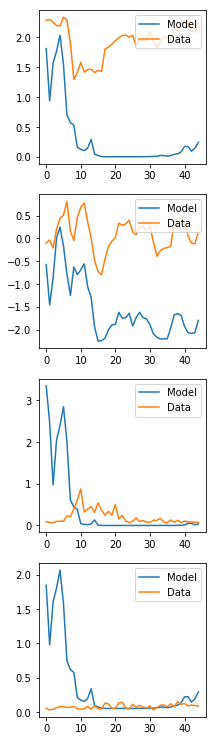

In [109]:
plt.figure(figsize=([3,13]))
for i,key in enumerate(ni_sim_moms_dct):
    plt.subplot(4,1,i+1)
    print(key)
    plt.plot(ni_sim_moms_dct[key],label='Model')
    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')
    plt.legend(loc=1)

In [ ]:
### simulated method of moment estimation for SCE

n_sim = 10
real_time = np.array(SCE_est['RTCPI'])
data_moms_dct = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

NI_model_sim2 = ni(real_time = real_time,
                   history = history_M,
                   process_para = process_paraM_est)
NI_model_sim2.GetDataMoments(data_moms_dct)
NI_model_sim2.moments = ['Forecast','FE','Disg']

sim_para = np.zeros([1,3])

for i in range(n_sim):
    NI_model_sim2.SimulateSignals()
    NI_model_sim2.GetRealization(realized_CPI)
    NI_model_sim2.ParaEstimate(para_guess=np.array([0.01,0.01,0.2]))
    print(NI_model_sim2.para_est)
    sim_para += NI_model_sim2.para_est
    
sigmas_est_SCE = sim_para/n_sim

In [40]:
print(sigmas_est_SCE)

[[7.02928921e-07 4.89750720e+00 2.00000000e-01]]
